# Linear regression

In [1]:
from Functions.Common_functions import *
import pandas as pd

### Load data

In [2]:
dataset_df = formate_dataset(normalizer=False)
dataset_df.head()

Relative Compactness Surface area Wall area Roof area Overall height  \
0             0.982928       530.49   306.485   112.003              7   
1             0.983547      519.872   299.776   110.048              7   
2             0.979453      516.191   303.374   106.408              7   
3             0.977733      518.924   292.812   113.056              7   
4             0.903029      552.969   316.236   118.366              7   

  Glazing area GAD : 0 GAD : 1 GAD : 2 GAD : 3 GAD : 4 GAD : 5 East North  \
0    0.0160949       1       0       0       0       0       0    0     1   
1  -0.00938681       1       0       0       0       0       0    1     0   
2 -0.000697494       1       0       0       0       0       0    0     0   
3  9.55443e-06       1       0       0       0       0       0    0     0   
4  -0.00659233       1       0       0       0       0       0    0     1   

  South West   Energy Energy efficiency  
0     0    0  34.2639                 B  
1     0    0  34.5898                 B  
2     1    0   38.778                 C  
3     0    1  37.9478                 C  
4     0    0  47.6759                 D

### Create test set

In [3]:
from sklearn.model_selection import train_test_split, cross_val_predict
X_train, X_test, y_train_r, y_test_r = train_test_split(dataset_df[dataset_df.columns[0:16]], dataset_df['Energy'], test_size=0.20, random_state=42)
_, _, y_train_b, y_test_b = train_test_split(dataset_df[dataset_df.columns[0:16]], dataset_df['Energy efficiency'], test_size=0.20, random_state=42) 

### Decision tree algorithm


In [4]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train, y_train_b)


DecisionTreeClassifier()

In [5]:
from graphviz import Source
from sklearn.tree import export_graphviz

def graphviz(out_file_name):
    export_graphviz(
    tree_clf, 
    out_file="C:\\Users\\User\\Documents\\Valdom\\ML\\Projet\\Python\\Graphiz\\"+out_file_name+".dot",
    feature_names=X_train.columns,
    class_names=tree_clf.classes_,
    rounded=True,
    filled= True
    )
    print("Graphiz créé")
    
graphviz(out_file_name="full_tree")

Graphiz créé


In [6]:
from IPython.display import IFrame
IFrame('Graphiz\\pdf\\full_tree.pdf', width=1000, height=300)

In [7]:
from sklearn.model_selection import cross_val_score
import numpy as np

print('Affichage de la validation croisée pour 3 lots :')
print(cross_val_score(tree_clf, X_train, y_train_b, cv=3))
print('Moyenne = %.2f' 
        % np.average(cross_val_score(tree_clf, X_train, y_train_b, cv=3)))

Affichage de la validation croisée pour 3 lots :
[0.54634146 0.61463415 0.53431373]
Moyenne = 0.56


To transform Graphiz into pdf, type the line command :
**dot -Tpdf Graphiz/full_tree.dot -o Graphiz/full_tree.pdf**

### Tree pruning

Greater values of ccp_alpha increase the number of nodes pruned

In [8]:
path = tree_clf.cost_complexity_pruning_path(X_train, y_train_b)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Impureté des feuilles vs alpha effectif dans le training set')

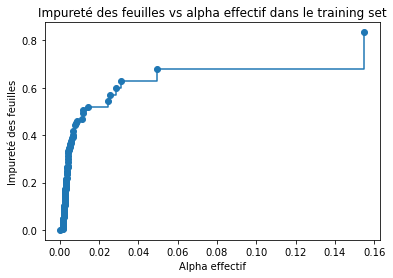

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")

ax.set_xlabel("Alpha effectif")
ax.set_ylabel("Impureté des feuilles")
ax.set_title("Impureté des feuilles vs alpha effectif dans le training set")


In [10]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train_b)
    clfs.append(clf)
print("Le nombre de noeuds dans le dernier arbre est : {} avec ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
print("Le nombre de noeuds dans l'avant-dernier arbre est : {} avec ccp_alpha: {}".format(
      clfs[-2].tree_.node_count, ccp_alphas[-2]))


Le nombre de noeuds dans le dernier arbre est : 1 avec ccp_alpha: 0.15498303192631346
Le nombre de noeuds dans l'avant-dernier arbre est : 3 avec ccp_alpha: 0.049471717725431796


We remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.
Here we show that the number of nodes and tree depth decreases as alpha increases.

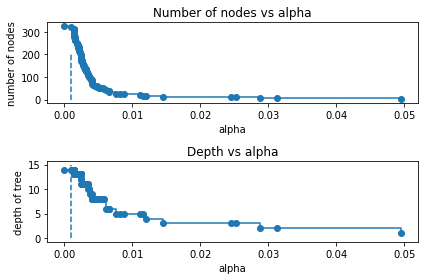

In [11]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[0].vlines(0.001, 0, 200, linestyles="--")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
ax[1].vlines(0.001, 0, 15, linestyles="--")
fig.tight_layout()

### Accuracy vs alpha for training and testing sets

In [12]:
from sklearn.model_selection import cross_val_score
train_scores = [clf.score(X_train, y_train_b) for clf in clfs]
test_scores = [clf.score(X_test, y_test_b) for clf in clfs]

cv_scores = []
for clf in clfs:
    cv_score = cross_val_score(estimator=clf, X=X_train, y=y_train_b, cv=3)
    cv_scores.append(cv_score.mean())


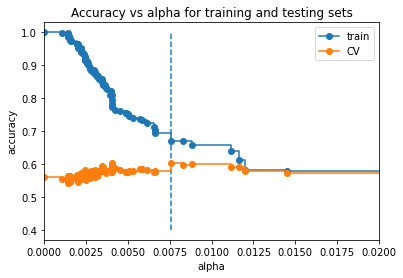

In [13]:
fig, ax = plt.subplots()
ax.set_xlim(0,0.02)
plt.vlines(0.0076, 0.4, 1, linestyles="--")
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, cv_scores, marker='o', label="CV",
        drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#         drawstyle="steps-post")
ax.legend()
plt.show()

We are going to choose a decision tree with an alpha = 0.0075


In [14]:
from sklearn.model_selection import GridSearchCV


opt_tree = GridSearchCV(estimator = tree.DecisionTreeClassifier(ccp_alpha=0.0075),
                        param_grid={'class_weight': ['balanced', None]},
                        scoring='f1_macro',
                        cv=3)
opt_tree.fit(X_train, y_train_b)
opt_tree.best_params_

{'class_weight': None}

## Test

In [15]:

graphviz(out_file_name="test_tree")
print('Coefficient de determination: %.2f'
    % opt_tree.best_estimator_.score(X_test, y_test_b))

Graphiz créé
Coefficient de determination: 0.64


In [16]:
from IPython.display import IFrame
IFrame('Graphiz\\pdf\\test_tree.pdf', width=1000, height=300)

In [17]:
print("We have removed {} depth layer(s) to have an optimal decision tree.".
      format((tree_clf.tree_.max_depth-opt_tree.best_estimator_.tree_.max_depth)))
print("We have prunned {} nodes to have an optimal decision tree.".
      format((tree_clf.tree_.node_count-opt_tree.best_estimator_.tree_.node_count)))



We have removed 8 depth layer(s) to have an optimal decision tree.
We have prunned 294 nodes to have an optimal decision tree.


## Errors analyse

In [18]:
from sklearn.metrics import classification_report

y_test_pred = opt_tree.best_estimator_.predict(X_test)
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.889     0.821     0.853        39
           B      0.346     0.643     0.450        14
           C      0.846     0.500     0.629        22
           D      0.667     0.571     0.615        14
           E      0.571     0.480     0.522        25
           F      0.516     0.667     0.582        24
           G      0.733     0.688     0.710        16

    accuracy                          0.643       154
   macro avg      0.653     0.624     0.623       154
weighted avg      0.687     0.643     0.652       154



In [19]:
from Functions.Classification_Functions import *

conf_mx = compute_conf_matrix(opt_tree.best_estimator_, X_test, y_test_b)

<Figure size 360x360 with 0 Axes>

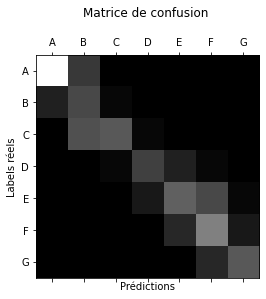

In [20]:
display_conf_matrix(conf_mx)

The model classfies well the A and F classes.

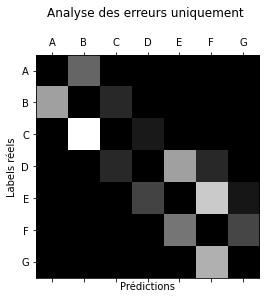

In [21]:
plot_error_analysis(conf_mx)

This model is laboring to classify well the B class. We can remark that this classifier is close to have very good results because the misclassified samples are almost always classify in the nearest class.